In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import os
import pickle

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
print("Checking for GPU availability...")
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print(f"GPU found: {physical_devices}")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Memory growth enabled for GPU")
else:
    print("No GPU found, using CPU")

Checking for GPU availability...
GPU found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Memory growth enabled for GPU


In [4]:
def load_data(file_path):
    print(f"Loading data from {file_path}...")
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
    df = df.set_index('date')
    print(f"Data loaded. Shape: {df.shape}")
    return df

In [5]:
def create_sequences(data, seq_length):
    print(f"Creating sequences with window size {seq_length}...")
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    print(f"Sequences created. X shape: {np.array(X).shape}, y shape: {np.array(y).shape}")
    return np.array(X), np.array(y)

In [6]:
def create_forecast_sequences(data, seq_length, forecast_horizon):
    print(f"Creating forecast sequences with window {seq_length} and horizon {forecast_horizon}...")
    X, y = [], []
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+forecast_horizon])
    print(f"Forecast sequences created. X shape: {np.array(X).shape}, y shape: {np.array(y).shape}")
    return np.array(X), np.array(y)

In [7]:
def calculate_metrics(y_true, y_pred, y_lower, y_upper):
    # Ensure data consistency
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    y_lower = y_lower.flatten()
    y_upper = y_upper.flatten()

    # Check for NaN values
    assert not np.isnan(y_true).any(), "y_true contains NaNs"
    assert not np.isnan(y_pred).any(), "y_pred contains NaNs"

    # RMSE Calculation
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # PICP Calculation
    within_interval = np.logical_and(y_true >= y_lower, y_true <= y_upper)
    picp = np.mean(within_interval)

    # MPIW Calculation
    mpiw = np.mean(y_upper - y_lower)

    return rmse, picp, mpiw

In [8]:
def create_train_model(X_train, y_train, forecast_horizon, model_dir):
    print("Creating and training MC Dropout model...")
    
    # Ensure the model directory exists
    os.makedirs(model_dir, exist_ok=True)
    
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(forecast_horizon)
    ])

    model.compile(optimizer='adam', loss='mse')

    checkpoint_path = os.path.join(model_dir, "mc_dropout_model.keras")
    
    checkpoint = ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        save_weights_only=False,
        verbose=1
    )
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[checkpoint, early_stopping],
        verbose=1
    )

    print("Model training completed")
    return model, history

In [ ]:
def generate_mc_dropout_forecasts(X_train, y_train, X_val, forecast_horizon, num_samples=30, save_results=True):
    print(f"Generating Monte Carlo Dropout forecasts with {num_samples} samples...")
    
    # Directory for model checkpoints
    model_dir = "model_checkpoints"
    os.makedirs(model_dir, exist_ok=True)
    
    # Directory for results
    results_dir = "forecast_results"
    os.makedirs(results_dir, exist_ok=True)
    
    # Create and train model
    model, _ = create_train_model(X_train, y_train, forecast_horizon, model_dir)
    
    # Create MC Dropout prediction function
    class MCDropoutModel(tf.keras.Model):
        def __init__(self, model):
            super(MCDropoutModel, self).__init__()
            self.model = model
            
        def call(self, inputs, training=True):
            return self.model(inputs, training=True)
    
    mc_model = MCDropoutModel(model)
    
    # Generate multiple predictions with dropout enabled
    print(f"Generating {num_samples} MC Dropout predictions...")
    forecasts = []
    
    for i in range(num_samples):
        print(f"MC Dropout sample {i+1}/{num_samples}")
        forecast = mc_model.predict(X_val, verbose=0)
        forecasts.append(forecast)
    
    forecasts = np.array(forecasts)
    print(f"Forecasts shape: {forecasts.shape}")
    
    print("Calculating statistics...")
    mean_forecast = np.mean(forecasts, axis=0)
    lower_bound = np.quantile(forecasts, 0.05, axis=0)
    upper_bound = np.quantile(forecasts, 0.95, axis=0)
    
    # Save forecasts and bounds to files
    if save_results:
        print("Saving forecast results to files...")
        results = {
            'mean_forecast': mean_forecast,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'forecasts': forecasts
        }
        
        results_path = os.path.join(results_dir, 'forecast_results.pkl')
        with open(results_path, 'wb') as f:
            pickle.dump(results, f)
        
        print(f"Results saved to {results_path}")
    
    print("Monte Carlo Dropout forecasting completed")
    return mean_forecast, lower_bound, upper_bound, model, forecasts

In [10]:
def load_forecast_results(results_dir="forecast_results"):
    print("Loading forecast results from file...")
    results_path = os.path.join(results_dir, 'forecast_results.pkl')
    
    if not os.path.exists(results_path):
        raise FileNotFoundError(f"Results file not found at {results_path}")
    
    with open(results_path, 'rb') as f:
        results = pickle.load(f)
    
    print("Forecast results loaded successfully")
    return results['mean_forecast'], results['lower_bound'], results['upper_bound'], results['forecasts']

In [11]:
def load_trained_model(model_dir="model_checkpoints"):
    print(f"Loading trained model from {model_dir}...")
    
    if not os.path.exists(model_dir):
        raise FileNotFoundError(f"Model directory {model_dir} not found")
    
    model_path = os.path.join(model_dir, "mc_dropout_model.keras")
    if os.path.exists(model_path):
        model = load_model(model_path)
        print("Model loaded successfully")
        return model
    else:
        raise FileNotFoundError(f"Model file {model_path} not found")

In [19]:
def predict_future_mc_dropout(model, last_sequence, future_steps, forecast_horizon, scaler, num_samples=30):
    print(f"Predicting future {future_steps} months with MC Dropout ({num_samples} samples)...")
    
    # Create MC Dropout prediction function
    class MCDropoutModel(tf.keras.Model):
        def __init__(self, model):
            super(MCDropoutModel, self).__init__()
            self.model = model
            
        def call(self, inputs, training=True):
            return self.model(inputs, training=True)
    
    mc_model = MCDropoutModel(model)
    
    future_predictions_samples = []
    
    for sample in range(num_samples):
        future_predictions = []
        curr_sequence = last_sequence.copy()
        
        steps_completed = 0
        while steps_completed < future_steps:
            curr_sequence_reshaped = curr_sequence.reshape(1, curr_sequence.shape[0], curr_sequence.shape[1])
            
            # Predict next forecast_horizon steps with dropout enabled
            next_preds = mc_model.predict(curr_sequence_reshaped, verbose=0)[0]
            
            # Add as many predictions as needed
            steps_to_add = min(forecast_horizon, future_steps - steps_completed)
            future_predictions.extend(next_preds[:steps_to_add])
            
            # Update the sequence for the next iteration
            curr_sequence = np.roll(curr_sequence, -steps_to_add, axis=0)
            curr_sequence[-steps_to_add:] = next_preds[:steps_to_add].reshape(-1, 1)
            
            steps_completed += steps_to_add
        
        future_predictions = np.array(future_predictions).reshape(-1, 1)
        future_predictions_samples.append(future_predictions)
        
        if (sample + 1) % 5 == 0:
            print(f"Completed {sample + 1}/{num_samples} MC Dropout samples")
    
    future_predictions_samples = np.array(future_predictions_samples)
    
    # Calculate statistics
    future_mean = np.mean(future_predictions_samples, axis=0)
    future_lower = np.quantile(future_predictions_samples, 0.05, axis=0)
    future_upper = np.quantile(future_predictions_samples, 0.95, axis=0)
    
    # Transform back to original scale
    future_mean = scaler.inverse_transform(future_mean)
    future_lower = scaler.inverse_transform(future_lower)
    future_upper = scaler.inverse_transform(future_upper)
    
    print("Future predictions with MC Dropout completed")
    return future_mean, future_lower, future_upper

In [13]:
def generate_future_dates(last_date, num_months):
    print(f"Generating {num_months} future dates from {last_date}...")
    future_dates = pd.date_range(start=last_date, periods=num_months+1, freq='MS')[1:]
    return future_dates

In [14]:
def calculate_evaluation_metrics(actual_values, mean_forecast_inv, lower_bound_inv, upper_bound_inv):
    rmse_values = []
    picp_values = []
    mpiw_values = []

    for i in range(len(actual_values)):
        rmse, picp, mpiw = calculate_metrics(
            actual_values[i],
            mean_forecast_inv[i],
            lower_bound_inv[i],
            upper_bound_inv[i]
        )
        rmse_values.append(rmse)
        picp_values.append(picp)
        mpiw_values.append(mpiw)

    print("\n===== EVALUATION METRICS =====")
    print(f"Average RMSE: {np.mean(rmse_values):.4f}")
    print(f"Average PICP: {np.mean(picp_values):.4f}")
    print(f"Average MPIW: {np.mean(mpiw_values):.4f}")
    print("==============================\n")
    
    return np.mean(rmse_values), np.mean(picp_values), np.mean(mpiw_values)

In [15]:
def plot_forecast(df, val_dates, mean_forecast_inv, lower_bound_inv, upper_bound_inv, 
                 future_dates, future_mean, future_lower, future_upper,
                 cycle_24_start, cycle_25_start, forecast_horizon):
    start_date = pd.to_datetime('1996-01-01')
    plt.figure(figsize=(15, 8))

    # Historical data from 1996
    historical_mask = df.index >= start_date
    plt.plot(df.index[historical_mask], df['ssn'][historical_mask], 'b-', label='Historical Data')

    # Validation predictions with uncertainty
    for i in range(len(mean_forecast_inv)):
        pred_dates = val_dates[i:i+forecast_horizon]
        if len(pred_dates) == len(mean_forecast_inv[i]):
            plt.plot(pred_dates, mean_forecast_inv[i], 'r-', alpha=0.5, label='Validation Predictions' if i == 0 else "")
            plt.fill_between(pred_dates, lower_bound_inv[i], upper_bound_inv[i], color='r', alpha=0.2, label='90% Confidence Interval' if i == 0 else "")

    # Future forecasts
    plt.plot(future_dates, future_mean, 'g-', label='Future Predictions')
    plt.fill_between(future_dates, future_lower.flatten(), future_upper.flatten(), color='g', alpha=0.2, label='Future 90% Confidence Interval')
    plt.axvline(x=cycle_24_start, color='k', linestyle='--', label='Cycle 24 Start')
    plt.axvline(x=cycle_25_start, color='k', linestyle='--', label='Cycle 25 Start')
    plt.title('Sunspot Number Forecast with Uncertainty')
    plt.xlabel('Date')
    plt.ylabel('Sunspot Number')
    plt.legend()
    plt.grid(True)
    plt.show()

Starting sunspot forecasting process...
Loading data from /Users/suryatejachalla/Projects/Solar-Data-Analysis/Data/processed/sunspot.csv...
Data loaded. Shape: (3301, 3)
Data summary:
               ssn         year        month
count  3301.000000  3301.000000  3301.000000
mean     81.844138  1886.541654     6.500151
std      63.049151    79.422777     3.452063
min       0.000000  1749.000000     1.000000
25%      25.700000  1818.000000     4.000000
50%      72.000000  1887.000000     7.000000
75%     119.600000  1955.000000     9.000000
max     285.000000  2024.000000    12.000000
Scaling data...
Data scaling completed
Defining cycle boundaries...
Splitting data for training and validation...
Training data points: 3245
Validation data points: 43
Creating training sequences...
Creating forecast sequences with window 96 and horizon 6...
Forecast sequences created. X shape: (3144, 96, 1), y shape: (3144, 6, 1)
Training sequences shape: (3144, 96, 1), (3144, 6, 1)
Creating validation sequ

/opt/anaconda3/envs/ssn/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0430
Epoch 1: val_loss improved from inf to 0.00543, saving model to model_checkpoints/mc_dropout_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0428 - val_loss: 0.0054
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0089
Epoch 2: val_loss improved from 0.00543 to 0.00427, saving model to model_checkpoints/mc_dropout_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0089 - val_loss: 0.0043
Epoch 3/100
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0065
Epoch 3: val_loss improved from 0.00427 to 0.00364, saving model to model_checkpoints/mc_dropout_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0065 - val_loss: 0.0036
Epoch 4/100
76/79 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0061
Epoch 4: val_loss improved from 0.00364 to 0.00267, saving model to model_checkpoints/mc_dropout_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0061 - val_loss: 0.0027
Epoch 5/100
78/7

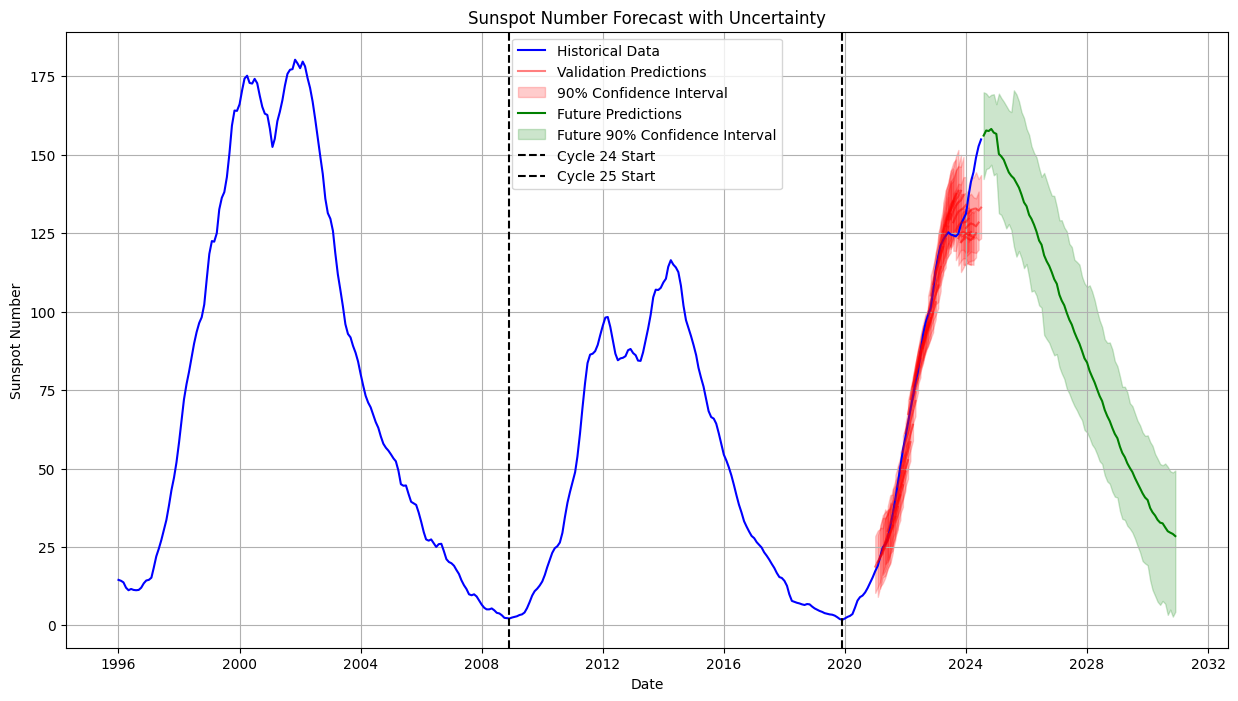

Forecasting process completed


In [21]:
if __name__ == "__main__":
    print("Starting sunspot forecasting process...")
    
    TRAIN_MODEL = True  # Set to False to load pre-trained model
    
    df = load_data('/Users/suryatejachalla/Projects/Solar-Data-Analysis/Data/processed/sunspot.csv')
    print("Data summary:")
    print(df.describe())

    print("Scaling data...")
    ssn = df['ssn'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    ssn_scaled = scaler.fit_transform(ssn)
    print("Data scaling completed")
    
    # Save scaler for later use
    with open('scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)

    print("Defining cycle boundaries...")
    cycle_24_start = pd.to_datetime('2008-12-01')
    cycle_25_start = pd.to_datetime('2019-12-01')
    validation_start = pd.to_datetime('2021-01-01')

    print("Splitting data for training and validation...")
    train_data = ssn_scaled[df.index < cycle_25_start]
    val_data = ssn_scaled[(df.index >= validation_start)]
    val_dates = df.index[(df.index >= validation_start)]
    print(f"Training data points: {len(train_data)}")
    print(f"Validation data points: {len(val_data)}")

    # Define forecast horizon
    forecast_horizon = 6  # 6 months

    print("Creating training sequences...")
    seq_length = 8 * 12  # 8 years in months
    X_train, y_train = create_forecast_sequences(train_data, seq_length, forecast_horizon)
    print(f"Training sequences shape: {X_train.shape}, {y_train.shape}")

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

    print("Creating validation sequences...")
    X_val = []
    y_val = []

    for i in range(len(val_dates) - forecast_horizon + 1):
        # Get the previous 8 years before the validation point
        start_idx = df.index.get_loc(val_dates[i]) - seq_length
        end_idx = df.index.get_loc(val_dates[i])
        forecast_end_idx = df.index.get_loc(val_dates[i]) + forecast_horizon

        if start_idx >= 0:
            X_val.append(ssn_scaled[start_idx:end_idx])
            y_val.append(ssn_scaled[end_idx:forecast_end_idx])

    X_val = np.array(X_val)
    y_val = np.array(y_val)

    # Reshape for LSTM
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
    print(f"Validation sequences shape: {X_val.shape}, {y_val.shape}")

    # Train or load model and generate MC Dropout samples
    num_samples = 100
    if TRAIN_MODEL:
        print("Starting Monte Carlo Dropout training and forecasting...")
        mean_forecast, lower_bound, upper_bound, model, forecasts = generate_mc_dropout_forecasts(
            X_train, y_train, X_val, forecast_horizon, num_samples=num_samples
        )
    else:
        print("Loading pre-trained model and forecast results...")
        mean_forecast, lower_bound, upper_bound, forecasts = load_forecast_results()
        model = load_trained_model()

    print("Transforming forecasts back to original scale...")
    # Reshape for inverse transform
    mean_forecast_reshaped = mean_forecast.reshape(-1, forecast_horizon)
    lower_bound_reshaped = lower_bound.reshape(-1, forecast_horizon)
    upper_bound_reshaped = upper_bound.reshape(-1, forecast_horizon)

    # Store original shapes for validation
    print(f"Mean forecast shape before transform: {mean_forecast_reshaped.shape}")
    print(f"Lower bound shape before transform: {lower_bound_reshaped.shape}")
    print(f"Upper bound shape before transform: {upper_bound_reshaped.shape}")

    # Transform back to original scale
    mean_forecast_inv = np.array([scaler.inverse_transform(f.reshape(-1, 1)).flatten() for f in mean_forecast_reshaped])
    lower_bound_inv = np.array([scaler.inverse_transform(f.reshape(-1, 1)).flatten() for f in lower_bound_reshaped])
    upper_bound_inv = np.array([scaler.inverse_transform(f.reshape(-1, 1)).flatten() for f in upper_bound_reshaped])

    print(f"Mean forecast shape after transform: {mean_forecast_inv.shape}")
    print(f"Lower bound shape after transform: {lower_bound_inv.shape}")
    print(f"Upper bound shape after transform: {upper_bound_inv.shape}")

    print("Computing actual values for validation period...")
    actual_values = []
    for i in range(len(y_val)):
        # Transform each sequence
        inv_y = scaler.inverse_transform(y_val[i].reshape(-1, 1)).flatten()
        actual_values.append(inv_y)

    actual_values = np.array(actual_values)
    print(f"Actual values shape: {actual_values.shape}")

    print("Calculating evaluation metrics...")
    avg_rmse, avg_picp, avg_mpiw = calculate_evaluation_metrics(
        actual_values, mean_forecast_inv, lower_bound_inv, upper_bound_inv
    )

    print("Preparing for future predictions...")
    last_sequence = ssn_scaled[-seq_length:].reshape(seq_length, 1)
    last_date = df.index[-1]
    future_steps = (2030 - last_date.year) * 12 + (12 - last_date.month)
    print(f"Forecasting {future_steps} months ahead, until 2030")
    future_dates = generate_future_dates(last_date, future_steps)

    print("Generating future forecasts with MC Dropout...")
    future_mean, future_lower, future_upper = predict_future_mc_dropout(
        model, last_sequence, future_steps, forecast_horizon, scaler, num_samples=num_samples
    )

    # Save future predictions
    future_results = {
        'future_mean': future_mean,
        'future_lower': future_lower,
        'future_upper': future_upper,
        'future_dates': future_dates
    }
    with open('future_predictions.pkl', 'wb') as f:
        pickle.dump(future_results, f)
    print("Future predictions saved to future_predictions.pkl")

    print("Creating visualization...")
    plot_forecast(
        df, val_dates, mean_forecast_inv, lower_bound_inv, upper_bound_inv,
        future_dates, future_mean, future_lower, future_upper,
        cycle_24_start, cycle_25_start, forecast_horizon
    )
    print("Forecasting process completed")